# Introduction to Business Analytics Project

In [3]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
#from tqdm import tqdm

import pickle

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import osmnx as ox
import holidays
from haversine import haversine, Unit
import shapely.geometry

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Dissable warnings
import warnings
warnings.filterwarnings('ignore')

# Setting seeds
np.random.seed(42)

# 1 Introduction

# 2 Data analysis and visualization

In [4]:
# Loading the dataset 
#data = pd.read_csv('Trips_2018.csv')
#data = pd.read_csv('/Users/sofiehultengren/Desktop/Skrivebord – MacBook Pro tilhørende Sofie/Uni/Kandidat /3. semester/42577 Business analytics/Assignment/Trips_2018.csv')
#data = pd.read_csv('/Users/Ejer/Desktop/DTU/Kandidat/3. Semester/Business analytics/Project/Trips_2018.csv')
data = pd.read_csv('/Users/camillasmithmuller/Desktop/UNI/42577 Introduction to business analytics/Project/Trips_2018.csv')
observations = data.shape[0]
attributes = data.shape[1]
print(f"Size of the dataset: {data.shape}")
print("Data snippet:")
data.head()

Size of the dataset: (17548339, 14)
Data snippet:


,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


As we can see, the dataset consists of 17,548,339 observations across 14 attributes. It includes key information about each bike trip, such as the start and end station IDs, trip duration, and the geographic coordinates (latitude and longitude) of the stations. Additionally, the dataset contains user-related information, including user type, birth year, and gender.

As part of the data preparation, all columns containing NaN values were removed from the dataset. Furthermore, both the start time and stop time variables were converted to datetime format. The “Unnamed” column, which served as an index column, was also removed.

In [5]:
# Dropping unnamed column
data.drop(["Unnamed: 0"], axis=1, inplace=True)

# Removing NaN-values
data.dropna(inplace=True) 

# Converting times and dates to datetime format
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])
data['date'] = data['starttime'].dt.date


print(f"Size of the dataset: {data.shape}")
print(f"Removed {observations-data.shape[0]} NaN-values")
print("Data snippet:")
data.head()

Size of the dataset: (17545842, 14)
Removed 2497 NaN-values
Data snippet:


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,date
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01


To bether understand the data - user analisys was apllied. looking into when the usage of the bikes was at it highest, as weel as how long the durations of the bikes usally where. 

The tripdurations where investigated for the data 

In [6]:
# Statistics of tripduration
print(f"""
Trip duration statistics (sec.):
Trip duration range (sec.): [{min(data['tripduration']):.2f}, {max(data['tripduration']):.2f}] 
Mean: {data['tripduration'].mean():.2f}
Median: {data['tripduration'].median():.2f}
STD:  {data['tripduration'].std():.2f}""")


Trip duration statistics (sec.):
Trip duration range (sec.): [61.00, 19510049.00] 
Mean: 988.47
Median: 605.00
STD:  18895.91


Based on this we can see that the maximum tripduration is much larger than both the mean and the median. This indicates that we have som kind of ourliers. 

To visualise the outliers, the histogram of the duration was plotted on poth linear and log axes

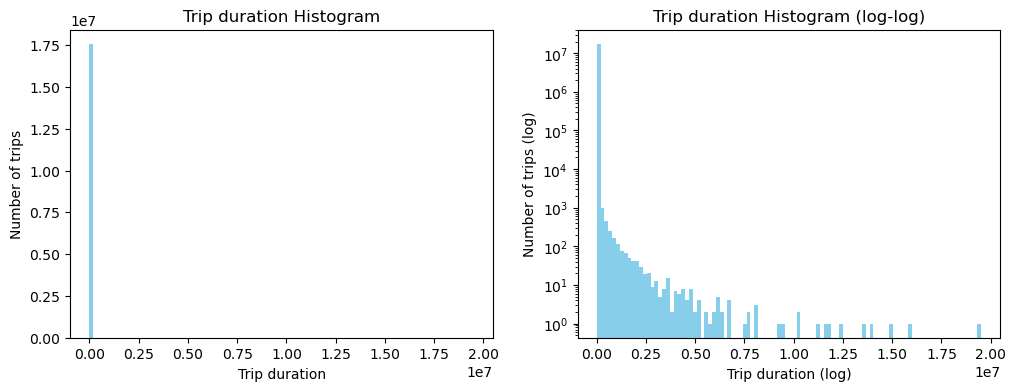

In [7]:
# Plotting the trip duration histogram on linear and log-log axes
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(data['tripduration'], bins=100, color='skyblue')
plt.xlabel('Trip duration')
plt.ylabel('Number of trips')
plt.title('Trip duration Histogram')

plt.subplot(122)
plt.hist(data['tripduration'], bins=100, log=True, color='skyblue')
plt.xlabel('Trip duration (log)')
plt.ylabel('Number of trips (log)')
plt.title('Trip duration Histogram (log-log)')
plt.show()

To improve the quality of the data, outliers were removed. Outliers were defined as trips with a duration above the 99th percentile.

In [8]:
#Removing outliers
data_wo_outliers = data[data['tripduration'] <= data['tripduration'].quantile(0.99)]
print(f"""Number of observations removed as outliers:", {data.shape[0] - data_wo_outliers.shape[0]})
Size of the dataset after removing outliers: {data_wo_outliers.shape}
Trip duration range (sec.) after removing outliers: [{min(data_wo_outliers['tripduration']):.2f}, {max(data_wo_outliers['tripduration']):.2f}]
Mean after removing outliers: {data_wo_outliers['tripduration'].mean():.2f}
Median after removing outliers: {data_wo_outliers['tripduration'].median():.2f}
STD after removing outliers:  {data_wo_outliers['tripduration'].std():.2f}
""")
print()

Number of observations removed as outliers:", 175403)
Size of the dataset after removing outliers: (17370439, 14)
Trip duration range (sec.) after removing outliers: [61.00, 3505.00]
Mean after removing outliers: 776.67
Median after removing outliers: 599.00
STD after removing outliers:  576.04




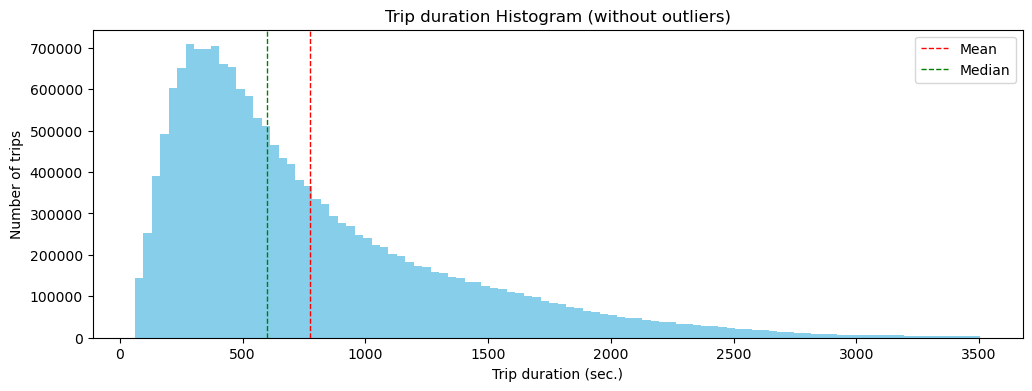

In [9]:
# Visualisng the histogram of the data without outliers 
plt.figure(figsize=(12, 4))
plt.hist(data_wo_outliers['tripduration'], bins=100, color='skyblue')
plt.xlabel('Trip duration (sec.)')
plt.ylabel('Number of trips')
plt.title('Trip duration Histogram (without outliers)')
plt.axvline(data_wo_outliers['tripduration'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(data_wo_outliers['tripduration'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()    
plt.show()


The histogram above shows the distribution of trip durations (in seconds) after removing extreme outliers from the dataset. The shape of the distribution is clearly right-skewed, meaning that most trips are relatively short, while a smaller number of trips take significantly longer.

Two vertical dashed lines are included for reference:

- Red dashed line: Mean trip duration  
- Green dashed line: Median trip duration  

Because the mean lies further to the right than the median, this confirms the right-skewness of the data.  
After removing outliers, the distribution becomes smoother and more interpretable, making it easier to understand the typical trip duration and the spread of the data.

## Usage patterns 
To better understand how the bikes are used, we analyze the usage across different time scales: **monthly**, **weekly**, and **daily**.  
The goal is to identify whether there are any clear patterns or tendencies in the data.
By breaking the usage down by these time dimensions, we can gain insights into seasonal trends, weekday vs. weekend behavior, and typical daily usage peaks.


In [10]:
def compute_hourly_df(df, cluster_id=None):
    """ 
    Creates three dataframes:
    1. Pickups:  hourly counts of trips that started in the cluster
    2. Dropoffs: hourly counts of trips that ended in the cluster
    3. Pickups and dropoffs merged into one dataframe

    :param df: Input dataframe containing starttime/stoptime + cluster columns
    :param cluster_id: (Optional) cluster to filter on
    :return: pickups, dropoffs, pickups_and_dropoffs
    """

    # Pickups dataframe
    if cluster_id is not None:
        pickups = df[df['start_cluster'] == cluster_id]['starttime'].value_counts().reset_index()
    else:
        pickups = df['starttime'].value_counts().reset_index()
    pickups.columns = ['time', 'pickups']
    pickups = pickups.set_index('time').sort_index()

    # Dropoffs dataframe
    if cluster_id is not None:
        dropoffs = df[df['end_cluster'] == cluster_id]['stoptime'].value_counts().reset_index()
    else:
        dropoffs = df['stoptime'].value_counts().reset_index()
    dropoffs.columns = ['time', 'dropoffs']
    dropoffs = dropoffs.set_index('time').sort_index()

    # Merge on timestamps and fill missing hours with 0
    pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer').fillna(0)

    return pickups, dropoffs, pickups_and_dropoffs


In [11]:
#Creating pickups dataframe
pickups = data_wo_outliers['starttime'].value_counts().reset_index()
pickups.columns = ['time', 'pickups']
pickups = pickups.set_index('time')
pickups.sort_index(inplace=True)

display(pickups.head()) 

# creating dropoff dataframe
dropoffs = data_wo_outliers['stoptime'].value_counts().reset_index()
dropoffs.columns = ['time', 'dropoffs']
dropoffs = dropoffs.set_index('time')
dropoffs.sort_index(inplace=True)
display(dropoffs.head()) 

# Merge dropoffs and pickups on index
pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)

# Adding weekdays and months to dataframe 
pickups_and_dropoffs['weekday'] = [d.weekday() for d in pickups_and_dropoffs.index]
pickups_and_dropoffs['month'] = [d.month for d in pickups_and_dropoffs.index]

# Sanity check:
print(f"""
Total amount of pickups = Total amount of dropoffs: {pickups['pickups'].sum()==dropoffs['dropoffs'].sum()}""")

,pickups
time,
2018-01-01 00:01:50.650,1
2018-01-01 00:02:43.918,1
2018-01-01 00:03:15.116,1
2018-01-01 00:06:43.709,1
2018-01-01 00:06:56.924,1


,dropoffs
time,
2018-01-01 00:05:07.438,1
2018-01-01 00:06:11.383,1
2018-01-01 00:12:59.450,1
2018-01-01 00:13:28.480,1
2018-01-01 00:13:39.792,1



Total amount of pickups = Total amount of dropoffs: True


Plotting the pickups and droppoff count for each month, to see if there are any months in the dataset where the bikes are used more frequently 

In [12]:
# Flooring starttime and stoptime to nearest hour
count_data = data_wo_outliers[['starttime', 'stoptime']]
count_data['starttime'] = count_data['starttime'].dt.floor('H')
count_data['stoptime'] = count_data['stoptime'].dt.floor('H')

# Calculating pickups and dropoffs per hour interval
pickups, dropoffs, pickups_and_dropoffs = compute_hourly_df(count_data)

# Adding weekdays and months to dataframe
pickups_and_dropoffs['weekday'] = [d.weekday() for d in pickups_and_dropoffs.index]
pickups_and_dropoffs['month'] = [d.month for d in pickups_and_dropoffs.index]

print(f""" Total amount of pickups = Total amount of dropoffs: {pickups['pickups'].sum()==dropoffs['dropoffs'].sum()}""")

 Total amount of pickups = Total amount of dropoffs: True


Plotting the pickups and droppoff count for each month, to see if there are any months in the dataset where the bikes are used more frequently 

In [13]:
# Plotting the pickups and dropoff counts for each month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'Oktober', 'November', 'December']
pickups_and_dropoffs_months = [pickups_and_dropoffs[pickups_and_dropoffs['month'] == i+1]['pickups'].sum() for i, month in enumerate(months)]

fig = go.Figure(data=[go.Bar(x=months, y=pickups_and_dropoffs_months, marker_color='skyblue')])
fig.update_layout(xaxis_title="Months", yaxis_title="Total Pickups", title="Monthly Pickups", title_x=0.5, width=900,  height=400)
fig.show()

From the plot above, we can see that bike usage is significantly higher during the warmer months of the year.  
Trips increase steadily from early spring and peak during the summer, indicating that good weather has a strong positive impact on bike demand.

Interestingly, the summer holiday period does not appear to reduce the number of trips.  
Instead, usage remains consistently high throughout June, July, and August, suggesting that the bikes are used frequently even when people might be on vacation.


In [14]:
# Plotting the pickups and dropoff counts for each weekday
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pickups_and_dropoffs_weekdays = [pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]['pickups'].sum() for i, day in enumerate(days)]

fig = go.Figure(data=[go.Bar(x=days, y=pickups_and_dropoffs_weekdays, marker_color='skyblue')])
fig.update_layout(xaxis_title="Weekdays", yaxis_title="Total Pickups", title="Weekly Pickups", title_x=0.5, width=900,  height=400)
fig.show()

When examining the weekly distribution of bike usage, we see that the number of trips is noticeably higher on weekdays compared to weekends.  
This pattern suggests that a large share of the trips are likely related to commuting or other routine weekday activities.

To further investigate this trend, we also look at how bike usage is distributed throughout the day.  
By analyzing the hourly patterns, we can determine whether there are clear morning and afternoon peaks consistent with typical commuting behaviour.


In [15]:
# Plotting the pickups in hourly intervals for every day of the week
fig = go.Figure()
for i, weekday in enumerate(days):
    weekdata = pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]
    grouped_data = weekdata.groupby(weekdata.index.hour).sum()[["pickups", "dropoffs"]]


    index = grouped_data.index
    pickups = grouped_data['pickups']
    fig.add_trace(go.Scatter(x=index, y=pickups, mode='lines', name=f'{weekday}'))

fig.update_layout(title='Number of trips pr hour of the day', xaxis_title='Hour of day', yaxis_title='Number of trips', title_x=0.5, width=900,  height=400)

for time in [7, 9, 16, 19]:
    fig.add_shape(type="line", x0=time, y0=0, x1=time, y1=300000, line=dict(color="RoyalBlue", width=1, dash="dot"))
fig.show()

From the hourly distribution, we observe two very clear peaks in bike usage, one between 7:00–9:00 and another between 16:00–19:00.  
These peaks align closely with typical morning and afternoon commuting hours.

This strongly suggests that many users rely on the bikes for traveling to and from work or school.  
In contrast, the usage outside these time windows is noticeably lower, supporting the interpretation that commuting is a dominant driver of bike demand on weekdays.


# 3 Clustering 

To perform clustering, we only need the unique station IDs along with their longitude and latitude. Therefore, these variables are extracted from the dataset, and the data is processed so that each station appears only once.

In [16]:
# Count how many times each station appears as a start station
start_usage = data_wo_outliers['start_station_id'].value_counts().reset_index()
start_usage.columns = ['station_id', 'start_count']

# Extract unique start stations with coordinates
start_stations = (
    data_wo_outliers
    .drop_duplicates('start_station_id')[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
    .rename(columns={
        'start_station_id': 'station_id',
        'start_station_latitude': 'latitude',
        'start_station_longitude': 'longitude'
    })
)

# Count how many times each station appears as an end station
end_usage = data_wo_outliers['end_station_id'].value_counts().reset_index()
end_usage.columns = ['station_id', 'end_count']

# Extract unique end stations with coordinates
end_stations = (
    data_wo_outliers
    .drop_duplicates('end_station_id')[['end_station_id', 'end_station_latitude', 'end_station_longitude']]
    .rename(columns={
        'end_station_id': 'station_id',
        'end_station_latitude': 'latitude',
        'end_station_longitude': 'longitude'
    })
)

# Combine start and end station lists and keep unique station IDs
all_stations = pd.concat([start_stations, end_stations])
unique_stations = all_stations.drop_duplicates('station_id')

# Merge start + end usage counts for each station
station_usage = pd.merge(start_usage, end_usage, on='station_id', how='outer').fillna(0)

# Add usage counts to the unique station table
unique_stations = pd.merge(unique_stations, station_usage, on='station_id', how='left').fillna(0)
unique_stations['counts'] = unique_stations['start_count'] + unique_stations['end_count']
# Total usage (pickups + dropoffs)
unique_stations['total_usage'] = unique_stations['start_count'] + unique_stations['end_count']

# Remove intermediate columns (optional)
unique_stations.drop(['start_count', 'end_count'], axis=1, inplace=True)

unique_stations.head()


,station_id,latitude,longitude,counts,total_usage
0,72.0,40.767272,-73.993929,76279.0,76279.0
1,79.0,40.719116,-74.006667,54312.0,54312.0
2,82.0,40.711174,-74.000165,20504.0,20504.0
3,83.0,40.683826,-73.976323,26611.0,26611.0
4,119.0,40.696089,-73.978034,6957.0,6957.0


In [17]:
# The unique stations are plotted below
fig = go.Figure(data=go.Scatter(
    x = unique_stations['longitude'],
    y = unique_stations['latitude'],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'coral',
    )
))

fig.update_layout(
    title = 'Location of stations',
    xaxis_title = 'Longitude',
    yaxis_title = 'Latitude',
)

fig.show()

Some of the stations is seen to be located faar away from NYC. These stations are localised as outliers, and is removed from the data. 

In [18]:
# Removing outliers from dataset
data_wo_outliers_1 = data_wo_outliers[(data_wo_outliers['start_station_latitude'] < 44) & (data_wo_outliers['start_station_longitude'] < -73.8)]
data_wo_outliers_1 = data_wo_outliers_1[(data_wo_outliers_1['end_station_latitude'] < 44) & (data_wo_outliers_1['end_station_longitude'] < -73.8)]

#Removing outliers from the unique stations dataframe
unique_stations_wo_outliers = unique_stations[(unique_stations['latitude'] < 44) & (unique_stations['longitude'] < -73.8)]
print(f"Number of stations removed as outlier stations: {unique_stations.shape[0] - unique_stations_wo_outliers.shape[0]}")

Number of stations removed as outlier stations: 2


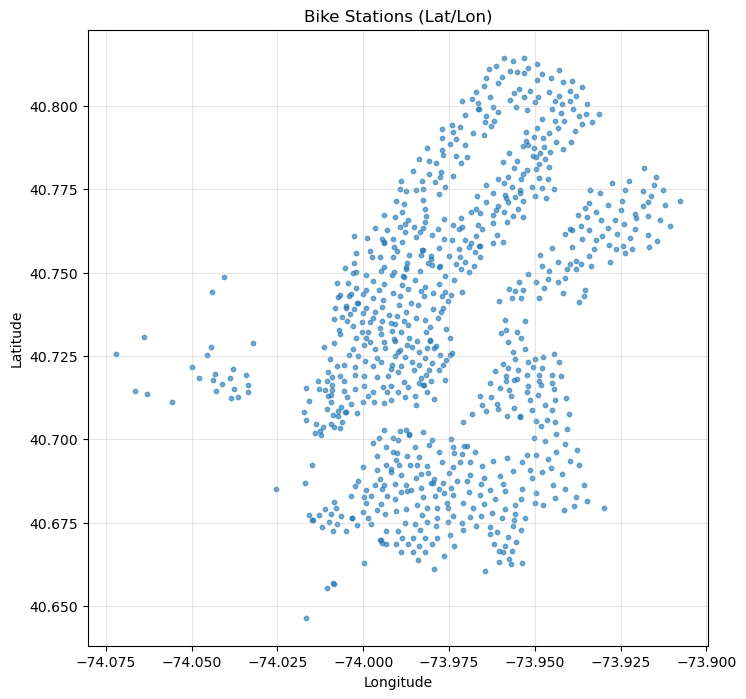

In [19]:
# Plotting the unique stations without outliers
plt.figure(figsize=(8, 8))
plt.scatter(
    unique_stations_wo_outliers['longitude'], 
    unique_stations_wo_outliers['latitude'], 
    s=10, 
    alpha=0.6
)

plt.title("Bike Stations (Lat/Lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)

plt.show()

To cluster the stations, a KMean is run, with 20 number of klusters. 

In [20]:
#Run K-means
coords = unique_stations_wo_outliers[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=20, random_state=42)
unique_stations_wo_outliers['cluster'] = kmeans.fit_predict(coords)

In [21]:
# Printing information about the highest-volume cluster
highest_vol_cluster = unique_stations_wo_outliers.groupby('cluster')['counts'].sum().reset_index().sort_values('counts', ascending=False).iloc[0]['cluster']
print(f"Highest Volume Cluster: {highest_vol_cluster}")

df_high_vol_cluster = unique_stations_wo_outliers[unique_stations_wo_outliers['cluster'] == highest_vol_cluster]
print(f"Amount of stations in cluster: {len(df_high_vol_cluster)}")
print(f"Amount of trips in cluster: {sum(df_high_vol_cluster['counts'])}")

Highest Volume Cluster: 1.0
Amount of stations in cluster: 65
Amount of trips in cluster: 6343535.0


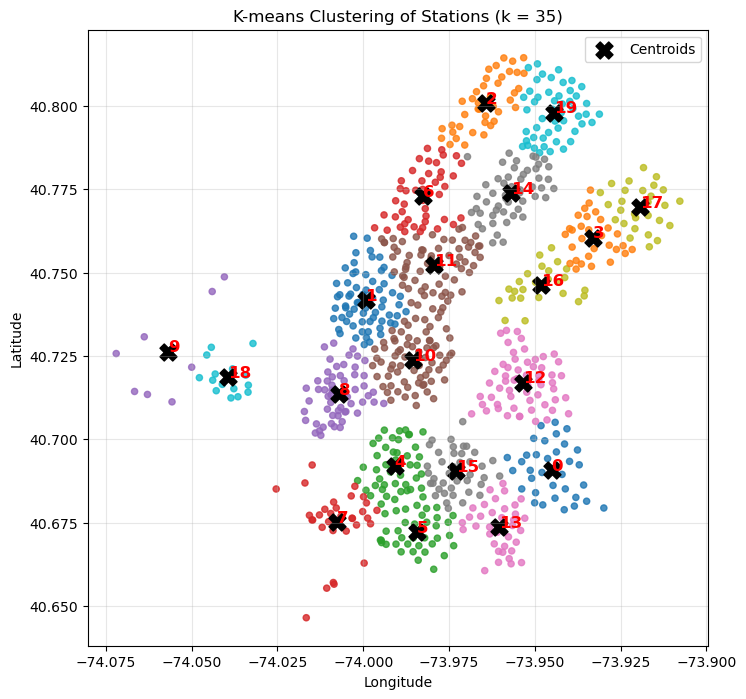

In [22]:
# Plotting the clustered stations
plt.figure(figsize=(8, 8))
plt.scatter(
    unique_stations_wo_outliers['longitude'],
    unique_stations_wo_outliers['latitude'],
    c=unique_stations_wo_outliers['cluster'],
    cmap='tab10',
    s=20,
    alpha=0.8
)

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=150, marker='X', label='Centroids'
)

# Add centroid labels
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon, lat,
        str(i),
        fontsize=12,
        fontweight='bold',
        color='red'
    )

plt.title("K-means Clustering of Stations (k = 35)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


To visualise where the clusters are located in New York, the clusters are plotted over a map of NYC.


In [23]:
# Plotting the clustered stations on top of NYC map
fig = go.Figure()

for cluster_id in sorted(unique_stations_wo_outliers['cluster'].unique()):
    cluster_data = unique_stations_wo_outliers[unique_stations_wo_outliers['cluster'] == cluster_id]

    fig.add_trace(go.Scattermapbox(
        lat=cluster_data['latitude'],
        lon=cluster_data['longitude'],
        mode='markers',
        marker=dict(size=7),
        name=f"Cluster {cluster_id}",  # vises i legend
        text=(
            "Station ID: " + cluster_data['station_id'].astype(str) +
            "<br>Cluster: " + cluster_data['cluster'].astype(str) +
            "<br>Lat: " + cluster_data['latitude'].round(5).astype(str) +
            "<br>Lon: " + cluster_data['longitude'].round(5).astype(str)
        ),
        hoverinfo="text"
    ))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(center=dict(lat=40.73, lon=-73.99), zoom=10),
    margin={"r":0, "t":0, "l":0, "b":0},
    title="Clustered Stations"
)

fig.show()


The clusters are added to the dataset

In [24]:
# Mapping station IDs to their cluster
station_to_cluster_dict = {row['station_id']: row['cluster'] for _, row in unique_stations_wo_outliers.iterrows()}
data_wo_outliers_1['start_cluster'] = data_wo_outliers_1['start_station_id'].map(station_to_cluster_dict)
data_wo_outliers_1['end_cluster'] = data_wo_outliers_1['end_station_id'].map(station_to_cluster_dict)

data_wo_outliers_1.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,date,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01,6.0,11.0
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01,6.0,1.0
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01,6.0,1.0
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01,6.0,6.0
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01,6.0,6.0


To obtain an overview of each cluster and the local demand for bikes, the number of pickups and dropoffs in each cluster can be visualised.

In [25]:
# Defining lists to hold pickup and dropoff counts
pickups = []
dropoffs = []

# Loop over each cluster
for i in range(20):
    pickups.append(len(data_wo_outliers_1[data_wo_outliers_1['start_cluster'] == i]))
    dropoffs.append(len(data_wo_outliers_1[data_wo_outliers_1['end_cluster'] == i]))

clusters = list(range(20))  # Cluster IDs

fig = go.Figure(data=[
    go.Bar(name='Pickups', x=clusters, y=pickups),
    go.Bar(name='Dropoffs', x=clusters, y=dropoffs)
])

# Change the bar mode
fig.update_layout(barmode='group', title='Pickups and Dropoffs for each Cluster')

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=clusters,
        ticktext=[str(c) for c in clusters] 
    ),
    title='Pickups and Dropoffs for each Cluster'
)

fig.show()


Here we observe that Cluster 1 has the highest number of both pickups and dropoffs.
To gain a clearer understanding of the activity level in each cluster, we display the number of pickups and dropoffs along with the difference between them.

In [26]:
# creating dataframe summarizing pickups and dropoffs per cluster
cluster_summary = pd.DataFrame({
    'cluster': list(range(20)),
    'pickups': pickups,
    'dropoffs': dropoffs
})

cluster_summary['difference'] = cluster_summary['pickups'] - cluster_summary['dropoffs']
cluster_summary

,cluster,pickups,dropoffs,difference
0,0,216180,214517,1663
1,1,3144267,3199268,-55001
2,2,560240,516607,43633
3,3,134296,134474,-178
4,4,746287,757624,-11337
5,5,377851,379436,-1585
6,6,1572042,1492473,79569
7,7,165580,175335,-9755
8,8,1818547,1859118,-40571
9,9,0,24,-24


We can see a clear variation across clusters, both in the balance between pickups and dropoffs and in the total number of bike trips. Some clusters have large imbalances, while others are more even, showing that demand for bikes differs noticeably across the city.

Mapping stations to cluster

Departures per cluster per hour

In [27]:
data_wo_outliers_1['hour_dep'] = data_wo_outliers_1['starttime'].dt.hour
hourly_dep = (
    data_wo_outliers_1.groupby(['start_cluster', 'hour_dep'])
        .size()
        .reset_index(name='pickups')
)
display(hourly_dep.head())

display(data_wo_outliers_1['hour_dep'].unique())

,start_cluster,hour_dep,pickups
0,0.0,0,2813
1,0.0,1,1818
2,0.0,2,1104
3,0.0,3,692
4,0.0,4,597


array([13, 15, 18, 21,  7,  8,  9, 10, 11, 12, 14, 16, 17, 19, 20, 22,  0,
        6,  5, 23,  1,  3,  4,  2], dtype=int32)

Arrivals per cluster per hour

In [28]:
data_wo_outliers_1['hour_arr'] = data_wo_outliers_1['stoptime'].dt.hour

hourly_arr = (
    data_wo_outliers_1.groupby(['end_cluster', 'hour_arr'])
        .size()
        .reset_index(name='dropoffs')
)
display(hourly_arr.head())

display(data_wo_outliers_1['hour_arr'].unique())

,end_cluster,hour_arr,dropoffs
0,0.0,0,5494
1,0.0,1,3152
2,0.0,2,1663
3,0.0,3,1023
4,0.0,4,735


array([14, 15, 18, 21,  8,  9, 10, 12, 13, 16, 17, 19, 20, 22, 23,  0,  7,
       11,  6,  5,  1,  3,  4,  2], dtype=int32)

Merging into one table per cluster and hour

In [29]:
hourly = (
    hourly_dep
    .merge(hourly_arr, left_on=['start_cluster','hour_dep'],
                        right_on=['end_cluster','hour_arr'],
           how='outer')
)

hourly.head(1000)


,start_cluster,hour_dep,pickups,end_cluster,hour_arr,dropoffs
0,0.0,0.0,2813.0,0.0,0,5494
1,0.0,1.0,1818.0,0.0,1,3152
2,0.0,2.0,1104.0,0.0,2,1663
3,0.0,3.0,692.0,0.0,3,1023
4,0.0,4.0,597.0,0.0,4,735
...,...,...,...,...,...,...
451,19.0,19.0,22213.0,19.0,19,27288
452,19.0,20.0,15311.0,19.0,20,21523
453,19.0,21.0,10780.0,19.0,21,15843
454,19.0,22.0,7932.0,19.0,22,12123


In [30]:
hourly[hourly['start_cluster']!=hourly['end_cluster']]

,start_cluster,hour_dep,pickups,end_cluster,hour_arr,dropoffs
216,NaN,NaN,NaN,9.0,11,3
217,NaN,NaN,NaN,9.0,13,1
218,NaN,NaN,NaN,9.0,15,1
219,NaN,NaN,NaN,9.0,16,1
220,NaN,NaN,NaN,9.0,18,1
221,NaN,NaN,NaN,9.0,19,5
222,NaN,NaN,NaN,9.0,20,4
223,NaN,NaN,NaN,9.0,21,6
224,NaN,NaN,NaN,9.0,23,2
417,NaN,NaN,NaN,18.0,9,7


# 4 Predicting the demand for each cluster of stations

## 3.2 Predicting the demand for a each cluster of stations

observation includes a timepoint along with the counts of pickups and dropoffs that happened in the following hour. This is applied to the highest volume cluster:

In [31]:
# PREPARING THE DATA FOR DEMAND PREDICTION
# We only keep the relevant columns for demand modeling
data_high_vol_cluster = data_wo_outliers_1[['starttime', 'stoptime', 'start_cluster', 'end_cluster']].copy()

# Convert timestamps to hourly resolution (crucial for time-series demand)
data_high_vol_cluster['starttime'] = pd.to_datetime(data_high_vol_cluster['starttime']).dt.floor('H')
data_high_vol_cluster['stoptime'] = pd.to_datetime(data_high_vol_cluster['stoptime']).dt.floor('H')

# Compute hourly pickups and dropoffs for the highest volume cluster
# This uses your previously defined helper function
pickups, dropoffs, pickups_and_dropoffs = compute_hourly_df(data_high_vol_cluster, highest_vol_cluster)

# Sanity check: verifying that aggregated data matches raw trip counts
print(f"""
Sanity check:
Amount of trips in cluster = pickups+dropoffs in cluster: {
    sum(df_high_vol_cluster['counts']) == 
    sum(pickups_and_dropoffs['pickups'] + pickups_and_dropoffs['dropoffs'])
}""")

# Display first rows of hourly demand
pickups_and_dropoffs.head()



Sanity check:
Amount of trips in cluster = pickups+dropoffs in cluster: True


,pickups,dropoffs
time,,
2018-01-01 00:00:00,22.0,20.0
2018-01-01 01:00:00,35.0,28.0
2018-01-01 02:00:00,16.0,18.0
2018-01-01 03:00:00,17.0,15.0
2018-01-01 04:00:00,9.0,9.0


With the dataframe defined, the following lagged features can be created:

- Lagged demand 1 hour back
- Lagged demand 24 hours back
- Lagged demand 168 hours back

The 1-hour lag causes predictions to depend on the previous hour which is not ideal, but will still be included. Additionally, based on the data analysis, features for *rushhour* (7am-10am and 4pm-7pm), *weekend*, *summer* and *holiday* will be created as these are hypothesized to have an impact on the demand. Since all features are within similar ranges, standardization is not necessary.

Since a model has to be fitted for each cluster, below `ClusterBuster` class is created to easily generate features and fit either a Linear Regression model, acting as a baseline, or a Random Forest Regressor (RFR):

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import holidays

class ClusterBuster:
    """
    ClusterBuster: A class for modeling hourly demand (pickups and dropoffs) for a given cluster of bike stations.
    
    This class performs:
        - Time preprocessing (hourly flooring)
        - Aggregation of hourly pickups/dropoffs
        - Creation of lag + calendar features
        - Train/test splitting (time-respecting)
        - Model creation (Linear Regression or Random Forest)
        - Prediction and evaluation
    """


    #  INITIALIZATION

    def __init__(self, cluster_id, cluster_df, baseline=False, print_info=True):

        # Store basic settings
        self.cluster_id = cluster_id
        self.print_info = print_info
        self.baseline = baseline

        # Keep only relevant columns for modeling
        self.cluster_df = cluster_df[['starttime', 'stoptime', 'start_cluster', 'end_cluster']].copy()

        # Storage variables for models, predictions, and data splits
        self.model_pickups = None
        self.model_dropoffs = None
        self.pickups = None
        self.dropoffs = None
        self.X_p = None
        self.y_p = None
        self.X_d = None
        self.y_d = None
        self.pred_pickups = None
        self.pred_dropoffs = None
        self.pickups_test = None
        self.dropoffs_test = None
        self.linear_model_metrics = None

        # Print initialization info
        if self.print_info:
            print(f"ClusterBuster object created for cluster {cluster_id}")

    
        #  FLOORING TIMESTAMPS (Time-series must be aligned to fixed intervals)
    
        self.cluster_df['starttime'] = pd.to_datetime(self.cluster_df['starttime']).dt.floor('H')
        self.cluster_df['stoptime'] = pd.to_datetime(self.cluster_df['stoptime']).dt.floor('H')

    
        #  CREATE HOURLY PICKUP TIME SERIES
    
        pickups = (
            self.cluster_df[self.cluster_df['start_cluster'] == self.cluster_id]['starttime']
            .value_counts()
            .reset_index()
        )
        pickups.columns = ['time', 'pickups']
        pickups = pickups.set_index('time').sort_index()

    
        #  CREATE HOURLY DROPOFF TIME SERIES
    
        dropoffs = (
            self.cluster_df[self.cluster_df['end_cluster'] == self.cluster_id]['stoptime']
            .value_counts()
            .reset_index()
        )
        dropoffs.columns = ['time', 'dropoffs']
        dropoffs = dropoffs.set_index('time').sort_index()

    
        #  MERGE PICKUPS & DROPOFFS INTO ONE TIME SERIES
    
        pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
        pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)  # hours with no activity

        # Store combined time series
        self.pickups_and_dropoffs = pickups_and_dropoffs


    #  FEATURE ENGINEERING

    def create_features(self, include=['rushhour', 'weekend', 'summer', 'holiday']):
        """
        Creates lag features + calendar/seasonal features.
        
        include: list of feature-category names to add
        """

        if self.print_info:
            print("Creating lag features...")

    
        #  LAG FEATURES (autocorrelation in demand)
    
        # Pickups
        self.pickups_and_dropoffs['1hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(1)
        self.pickups_and_dropoffs['24hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(24)
        self.pickups_and_dropoffs['168hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(168)

        # Dropoffs
        self.pickups_and_dropoffs['1hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(1)
        self.pickups_and_dropoffs['24hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(24)
        self.pickups_and_dropoffs['168hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(168)

        # Replace NaNs caused by lagging at the beginning of the series
        self.pickups_and_dropoffs.replace(np.nan, 0, inplace=True)

    
        #  RUSH HOUR FEATURE
    
        if 'rushhour' in include:
            if self.print_info:
                print("Creating rushhour feature")

            self.pickups_and_dropoffs['rushhour'] = 0
            # Morning peak: 7–10
            self.pickups_and_dropoffs.loc[
                (self.pickups_and_dropoffs.index.hour >= 7) &
                (self.pickups_and_dropoffs.index.hour <= 10),
                'rushhour'
            ] = 1
            # Evening peak: 16–19
            self.pickups_and_dropoffs.loc[
                (self.pickups_and_dropoffs.index.hour >= 16) &
                (self.pickups_and_dropoffs.index.hour <= 19),
                'rushhour'
            ] = 1

    
        #  WEEKEND FEATURE
    
        if 'weekend' in include:
            if self.print_info:
                print("Creating weekend feature")

            self.pickups_and_dropoffs['weekend'] = 0
            self.pickups_and_dropoffs.loc[
                (self.pickups_and_dropoffs.index.dayofweek >= 5),
                'weekend'
            ] = 1

    
        #  SUMMER SEASONALITY
    
        if 'summer' in include:
            if self.print_info:
                print("Creating summer feature")

            self.pickups_and_dropoffs['summer'] = 0
            self.pickups_and_dropoffs.loc[
                (self.pickups_and_dropoffs.index.month >= 4) &
                (self.pickups_and_dropoffs.index.month <= 9),
                'summer'
            ] = 1

    
        #  HOLIDAY FEATURE via US calendar
    
        if 'holiday' in include:
            if self.print_info:
                print("Creating holiday feature")

            self.pickups_and_dropoffs['holiday'] = 0
            us_holidays = holidays.UnitedStates()

            # Temporary date column because index stores timestamps
            self.pickups_and_dropoffs['date'] = self.pickups_and_dropoffs.index.date

            # Flag all dates that are holidays
            for date in self.pickups_and_dropoffs['date'].unique():
                if date in us_holidays:
                    self.pickups_and_dropoffs.loc[
                        self.pickups_and_dropoffs['date'] == date,
                        'holiday'
                    ] = 1

            self.pickups_and_dropoffs.drop('date', axis=1, inplace=True)

    
        #  SAVE WHICH COLUMNS ARE FEATURES
    
        self.features = self.pickups_and_dropoffs.columns.drop(['pickups', 'dropoffs'])

        if self.print_info:
            print(f"Features created for cluster {self.cluster_id}")
            print(f"Features used: {list(self.features)}")

    
        #  BUILD FINAL PICKUP/DROPOFF DATAFRAMES
    
        self.pickups = self.pickups_and_dropoffs[["pickups"] + list(self.features)]
        self.dropoffs = self.pickups_and_dropoffs[["dropoffs"] + list(self.features)]

    
        #  TRAIN/TEST SPLIT (IMPORTANT: NO SHUFFLING!)
    
        self.pickups_train = self.pickups.loc[self.pickups.index.month <= 10]
        self.pickups_test = self.pickups.loc[self.pickups.index.month >= 11]

        self.dropoffs_train = self.dropoffs.loc[self.dropoffs.index.month <= 10]
        self.dropoffs_test = self.dropoffs.loc[self.dropoffs.index.month >= 11]

        # Assign features/target matrices
        self.X_p = self.pickups_train[self.features]
        self.y_p = self.pickups_train["pickups"]

        self.X_d = self.dropoffs_train[self.features]
        self.y_d = self.dropoffs_train["dropoffs"]

    
        #  ENSURE TEST SET HAS FULL HOURLY RANGE
    
        # Fill missing timestamps with zeros (common in sparse mobility data)
        def fill_missing_hours(df, end_date="2019-01-01"):
            full_range = pd.date_range(start=df.index.min(), end=end_date, freq='H')
            if len(full_range) != len(df):
                missing = list(set(full_range) - set(df.index))
                for t in missing:
                    df.loc[t] = 0
                df.sort_index(inplace=True)

        fill_missing_hours(self.pickups_test)
        fill_missing_hours(self.dropoffs_test)

        if self.print_info:
            print("Length of pickup test set:", len(self.pickups_test))
            print("Length of dropoff test set:", len(self.dropoffs_test))


    #  MODEL CREATION

    def create_model(self):
        """
        Creates either:
            - Baseline Linear Regression model
            - Random Forest Regressor model
        """

        if self.baseline:
            # Simple linear baseline
            self.model_pickups = LinearRegression()
            self.model_dropoffs = LinearRegression()
        else:
            # Strong nonlinear model for forecasting
            self.model_pickups = RandomForestRegressor(
                n_estimators=100, max_depth=10, random_state=42
            )
            self.model_dropoffs = RandomForestRegressor(
                n_estimators=100, max_depth=10, random_state=42
            )

        if self.print_info:
            print("=" * 50)
            print(f"Models created for cluster {self.cluster_id}")
            print("Fitting models on training data...")

        # Fit both models
        self.model_pickups.fit(self.X_p, self.y_p)
        self.model_dropoffs.fit(self.X_d, self.y_d)

        if self.print_info:
            print("Models fitted successfully.")
            print("=" * 50)


    # PREDICTION

    def predict(self):
        """Predict hourly pickups and dropoffs on the test set."""
        self.pred_pickups = self.model_pickups.predict(self.pickups_test[self.features])
        self.pred_dropoffs = self.model_dropoffs.predict(self.dropoffs_test[self.features])


    #  METRICS

    def metrics(self, format_print=False):
        """
        Computes:
            - MSE  (Mean Squared Error)
            - MAE  (Mean Absolute Error)
            - R²   (Training R² score)
        """

        metrics = {
            "pickups": {
                "MSE": mean_squared_error(self.pickups_test["pickups"], self.pred_pickups),
                "MAE": mean_absolute_error(self.pickups_test["pickups"], self.pred_pickups),
                "R2": self.model_pickups.score(self.X_p, self.y_p)
            },
            "dropoffs": {
                "MSE": mean_squared_error(self.dropoffs_test["dropoffs"], self.pred_dropoffs),
                "MAE": mean_absolute_error(self.dropoffs_test["dropoffs"], self.pred_dropoffs),
                "R2": self.model_dropoffs.score(self.X_d, self.y_d)
            }
        }

        # Optional formatted output
        if format_print and self.print_info:
            for section, stats in metrics.items():
                print(f"Results for {section.capitalize()}:")
                for name, value in stats.items():
                    print(f"  {name}: {value:.4f}")
                print()

        return metrics


To test the ClusterBuster, it is used on the highest volume cluster to create a dataframe with pickups, dropoffs, lagged and boolean features:

In [33]:
#  BASELINE VS. RANDOM FOREST PREDICTION MODELS

# Create ClusterBuster instance for highest-volume cluster
# Full verbose output ON (print_info=True)

cluster_buster = ClusterBuster(highest_vol_cluster, data_wo_outliers_1)

# Create all features (lag features + calendar features)
cluster_buster.create_features()

# Display resulting feature table
cluster_buster.pickups_and_dropoffs.head()

ClusterBuster object created for cluster 1.0
Creating lag features...
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 1.0
Features used: ['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs', '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer', 'holiday']
Length of pickup test set: 1465
Length of dropoff test set: 1465


,pickups,dropoffs,1hLagPickups,24hLagPickups,168hLagPickups,1hLagDropoffs,24hLagDropoffs,168hLagDropoffs,rushhour,weekend,summer,holiday
time,,,,,,,,,,,,
2018-01-01 00:00:00,22.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
2018-01-01 01:00:00,35.0,28.0,22.0,0.0,0.0,20.0,0.0,0.0,0,0,0,1
2018-01-01 02:00:00,16.0,18.0,35.0,0.0,0.0,28.0,0.0,0.0,0,0,0,1
2018-01-01 03:00:00,17.0,15.0,16.0,0.0,0.0,18.0,0.0,0.0,0,0,0,1
2018-01-01 04:00:00,9.0,9.0,17.0,0.0,0.0,15.0,0.0,0.0,0,0,0,1


In [34]:
#  BASELINE MODEL (LINEAR REGRESSION)

# Create a separate instance with baseline=True
lin_reg = ClusterBuster(highest_vol_cluster, data_wo_outliers_1, baseline=True)

# Generate features for baseline model
lin_reg.create_features()

# Create and fit a Linear Regression model
lin_reg.create_model()

# Generate predictions for the test set (Nov–Dec)
lin_reg.predict()

# Print performance metrics (MSE, MAE, R2)
metrics = lin_reg.metrics(format_print=True)

ClusterBuster object created for cluster 1.0
Creating lag features...
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 1.0
Features used: ['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs', '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer', 'holiday']
Length of pickup test set: 1465
Length of dropoff test set: 1465
Models created for cluster 1.0
Fitting models on training data...
Models fitted successfully.
Results for Pickups:
  MSE: 11720.6690
  MAE: 71.1553
  R2: 0.8730

Results for Dropoffs:
  MSE: 11860.1768
  MAE: 71.1533
  R2: 0.8807



In [35]:
# Main model (RANDOM FOREST REGRESSOR)


# Create a non-baseline instance (Random Forest), printing disabled
cluster_buster = ClusterBuster(highest_vol_cluster, data_wo_outliers_1, print_info=False)

# Create fewer features (excluding holidays to reduce noise)
cluster_buster.create_features(include=['rushhour', 'weekend', 'summer'])

# Create and train Random Forest models for pickups & dropoffs
cluster_buster.create_model()

# Predict demand on test period
cluster_buster.predict()

# Store evaluation metrics
metrics = cluster_buster.metrics()


In [36]:
# PLOTTING ACTUAL VS PREDICTED DEMAND OVER TIME


marker_dict = dict(size=5, opacity=0.5)

# Create two side-by-side subplots: pickups (left), dropoffs (right)
fig = make_subplots(
    rows=1, cols=2, horizontal_spacing=0.1,
    subplot_titles=('Pickups over Time', 'Dropoffs over Time')
)


# Left: Actual vs Predicted Pickups

# Actual values
fig.add_trace(
    go.Scatter(
        x=pickups.index,
        y=pickups['pickups'],
        mode='markers',
        marker=marker_dict,
        name='Actual Pickups'
    ),
    row=1, col=1
)

# Predicted values
fig.add_trace(
    go.Scatter(
        x=cluster_buster.pickups_test.index,
        y=cluster_buster.pred_pickups,
        mode='markers',
        marker=marker_dict,
        name='Predicted Pickups'
    ),
    row=1, col=1
)

fig.update_xaxes(title_text="Time", row=1, col=1)
fig.update_yaxes(title_text="Pickups", row=1, col=1)



# Right: Actual vs Predicted Dropoffs

fig.add_trace(
    go.Scatter(
        x=dropoffs.index,
        y=dropoffs['dropoffs'],
        mode='markers',
        marker=marker_dict,
        name='Actual Dropoffs'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=cluster_buster.dropoffs_test.index,
        y=cluster_buster.pred_dropoffs,
        mode='markers',
        marker=marker_dict,
        name='Predicted Dropoffs'
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Time", row=1, col=2)
fig.update_yaxes(title_text="Dropoffs", row=1, col=2)

# Layout settings
fig.update_layout(width=900, height=400)
fig.show()

In [37]:
#  SCATTER PLOTS + RESIDUAL HISTOGRAMS


fig = make_subplots(
    rows=2, cols=2,
    horizontal_spacing=0.1, vertical_spacing=0.1,
    subplot_titles=(
        'Predicted vs. Actual Pickups',
        'Predicted vs. Actual Dropoffs',
        'Residuals Pickups',
        'Residuals Dropoffs'
    )
)


# Predicted vs Actual Pickups

fig.add_trace(
    go.Scatter(
        x=cluster_buster.pred_pickups,
        y=cluster_buster.pickups_test['pickups'],
        mode='markers',
        name='True vs Pred.'
    ),
    row=1, col=1
)

# Line of perfect predictions
fig.add_trace(
    go.Scatter(
        x=[0, 1500], y=[0, 1500],
        mode='lines',
        name='Perfect fit'
    ),
    row=1, col=1
)

fig.update_xaxes(title_text="Predicted Pickups", row=1, col=1)
fig.update_yaxes(title_text="Actual Pickups", row=1, col=1)



# Predicted vs Actual Dropoffs

fig.add_trace(
    go.Scatter(
        x=cluster_buster.pred_dropoffs,
        y=cluster_buster.dropoffs_test['dropoffs'],
        mode='markers',
        name='True vs Pred.'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=[0, 1500], y=[0, 1500],
        mode='lines',
        name='Perfect fit'
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Predicted Dropoffs", row=1, col=2)
fig.update_yaxes(title_text="Actual Dropoffs", row=1, col=2)



# Residual Histogram (Pickups)

fig.add_trace(
    go.Histogram(
        x=cluster_buster.pickups_test['pickups'] - cluster_buster.pred_pickups,
        name='Residuals Pickups'
    ),
    row=2, col=1
)

fig.update_xaxes(title_text="Residuals", row=2, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)



# Residual Histogram (Dropoffs)

fig.add_trace(
    go.Histogram(
        x=cluster_buster.dropoffs_test['dropoffs'] - cluster_buster.pred_dropoffs,
        name='Residuals Dropoffs'
    ),
    row=2, col=2
)

fig.update_xaxes(title_text="Residuals", row=2, col=2)
fig.update_yaxes(title_text="Frequency", row=2, col=2)


# Final layout
fig.update_layout(width=900, height=800)
fig.show()

# 4.2 Demand

### Computing the minimum number of bikes needed for a single day

We now want to know how many bicycles must be placed in a cluster **overnight** so that, during the next day, the system never runs out of bikes (or at least minimizes shortages).

For a given day, we assume:
- `pred_pickups` ≈ predicted **departures** (bikes taken from the cluster),  
- `pred_dropoffs` ≈ predicted **arrivals** (bikes returned to the cluster).

If we start the day with \( B_0 \) bikes in the cluster, then at any time \( t \) during the day the number of bikes left is:

\[
B(t) = B_0 + \text{cum\_arrivals}(t) - \text{cum\_departures}(t)
\]

To **never** run out of bikes, we need \( B(t) \ge 0 \) for all \( t \).  
Rearranging:

\[
B_0 \ge \text{cum\_departures}(t) - \text{cum\_arrivals}(t) \quad \forall t
\]

So the **minimum** feasible \( B_0 \) is the **maximum** value of  
\(\text{cum\_departures}(t) - \text{cum\_arrivals}(t)\) over the whole day.

The function below:
- takes a DataFrame for one day with the predicted pickups and dropoffs,
- computes cumulative sums,
- finds the maximum difference between cumulative departures and arrivals,
- returns this value as the **required starting number of bikes** for that day (and clips to 0 if arrivals are always higher).


In [38]:
import pandas as pd
import numpy as np

def required_bikes_for_day(day_df):
    """
    Compute minimum number of bikes that must be present at the **start**
    of this day so that the station/cluster never runs out of bikes,
    given predicted hourly pickups (departures) and dropoffs (arrivals).

    day_df must have columns:
        - 'pred_pickups'
        - 'pred_dropoffs'
    and an hourly DateTimeIndex for that day.
    """

    # Cumulative number of predicted departures and arrivals
    cum_departures = day_df["pred_pickups"].cumsum()
    cum_arrivals   = day_df["pred_dropoffs"].cumsum()

    # At any time t, if we start with B0 bikes, we need:
    #     B0 >= cum_departures(t) - cum_arrivals(t)
    # So the minimum B0 is the maximum of that difference over the day.
    diff = cum_departures - cum_arrivals
    needed = diff.max()

    # If arrivals are always >= departures, this will be <= 0 → need 0 bikes.
    return max(0, needed)


We now build and train the prediction model for the selected cluster by creating the required features, fitting the model, and generating hourly predictions of pickups and dropoffs that will be used to calculate the number of bikes needed for the next day.


In [39]:
cluster_buster = ClusterBuster(highest_vol_cluster, data_wo_outliers_1, print_info=False)
cluster_buster.create_features(include=['rushhour', 'weekend', 'summer'])
cluster_buster.create_model()
cluster_buster.predict()


### Applying the bike requirement calculation to all days in the test period

The helper function above works for **one day** at a time.  
Next, we want to apply this logic to **every day** in the test period for a given cluster.

From the `ClusterBuster` object we already have:
- `cluster_buster.pred_pickups`: model predictions of hourly pickups,  
- `cluster_buster.pred_dropoffs`: model predictions of hourly dropoffs,  
- `cluster_buster.pickups_test.index`: the DateTime index for the test period (hourly).

We now:
1. Build a DataFrame `df_pred` with:
   - one row per hour in the test set,
   - columns for predicted pickups and dropoffs.
2. Group this DataFrame **by calendar day** (using the date part of the index).
3. For each day, call `required_bikes_for_day` to compute the **minimum initial stock of bikes** needed for that day.
4. Collect these values in `daily_required`, which tells us, for each day in the test period, how many bikes we should place in that cluster overnight.

This gives us a day-by-day bike allocation recommendation for the cluster based on the prediction model.


In [40]:
def compute_required_bikes_per_day(cluster_buster):
    """
    Uses the predictions from a ClusterBuster instance
    to compute the required starting bikes for each day
    in the test period (Nov–Dec) for that cluster.
    """

    # DataFrame with hourly predictions on the test period
    df_pred = pd.DataFrame({
        "pred_pickups":  cluster_buster.pred_pickups,
        "pred_dropoffs": cluster_buster.pred_dropoffs
    }, index=cluster_buster.pickups_test.index)

    # Group by calendar day and compute bikes needed for each day
    daily_required = (
        df_pred
        .groupby(df_pred.index.date)
        .apply(required_bikes_for_day)
        .to_frame(name="required_bikes")
    )

    # Optional: make the index a proper DateIndex
    daily_required.index = pd.to_datetime(daily_required.index)

    return df_pred, daily_required


# ---- run it for your main cluster ----
df_pred_cluster, required_bikes_cluster = compute_required_bikes_per_day(cluster_buster)

required_bikes_cluster.head()


,required_bikes
2018-11-01,226.252254
2018-11-02,199.563783
2018-11-03,32.324830
2018-11-04,43.819488
2018-11-05,226.326157


The required bikes fluctuate significantly across the test period, indicating that demand patterns are highly day-dependent. Some days require only a small buffer of bikes, while others need substantially more to cover peaks in predicted departures.

### Inspecting one example day

To better understand and illustrate what the model is doing, we can zoom in on a **single day** from the test period.

Here we:
- Select one example day from `required_bikes_cluster`,
- Extract the corresponding hourly predictions from `df_pred_cluster`,
- Reuse the `required_bikes_for_day` function to compute the required starting bikes for that day,
- Print the result.

This is useful both for debugging and for the report, where we can show:
- the chosen day,
- the maximum difference between cumulative departures and arrivals,
- and how this translates into the recommended number of bikes to place overnight.


In [41]:
# Pick an example day from the test set
example_day = required_bikes_cluster.index[0]   # e.g. first Nov day
day_mask    = df_pred_cluster.index.date == example_day.date()
day_df      = df_pred_cluster.loc[day_mask]

needed_example = required_bikes_for_day(day_df)
print(f"Required bikes for cluster {cluster_buster.cluster_id} on {example_day.date()}: {needed_example:.1f}")


Required bikes for cluster 1.0 on 2018-11-01: 226.3


### Extending the analysis to multiple clusters

So far we have computed the required number of bikes for a **single cluster**.  
In reality, the bike-sharing company manages several clusters and must decide how many bikes to place in each of them overnight.

To generalize our approach, we:
1. Define a list of cluster IDs to analyze.
2. For each cluster:
   - create a new `ClusterBuster` instance,
   - build features, train the prediction model, and generate hourly predictions,
   - compute `daily_required` using the same logic as before.
3. Store the daily bike requirements for each cluster in a dictionary.

This allows us to:
- compare the required starting bikes across clusters on the same day,
- understand where demand is strongest,
- and support a **global repositioning strategy** across all clusters.


In [45]:
clusters_to_analyze = [highest_vol_cluster, 2, 5, 7, 12]
results = {}

for cid in clusters_to_analyze:
    cb = ClusterBuster(cid, data_wo_outliers_1, print_info=False)
    cb.create_features(include=['rushhour', 'weekend', 'summer'])
    cb.create_model()
    cb.predict()

    _, daily_req = compute_required_bikes_per_day(cb)
    results[cid] = daily_req

# Example: show required bikes for each cluster on the same example day
example_day = list(results.values())[0].index[0]
for cid, daily_req in results.items():
    print(f"Cluster {cid}, {example_day.date()}: {daily_req.loc[example_day, 'required_bikes']:.1f} bikes")


Cluster 1.0, 2018-11-01: 226.3 bikes
Cluster 2, 2018-11-01: 481.2 bikes
Cluster 5, 2018-11-01: 152.7 bikes
Cluster 7, 2018-11-01: 29.9 bikes
Cluster 12, 2018-11-01: 250.9 bikes


The results show large variations in how many bikes each cluster needs at the start of the day.
Cluster 2 clearly stands out with ~481 bikes, which is roughly double the next-highest cluster. This indicates that Cluster 2 experiences a strong imbalance between morning departures and arrivals — meaning many people take bikes out of this area early in the day. Cluster 2 covers Midtown and the Upper East Side, an area with dense residential zones, major transit hubs, universities, hospitals, and tourist attractions; as a result it experiences a strong morning departure peak and therefore requires the largest overnight bike allocation.

Clusters 1 and 12 also require high initial stocks (226 and 251 bikes), suggesting moderate commuter pressure, while clusters 5 and 7 have much lower requirements, reflecting more balanced flows.

Clusters 1 and 12 both lie in dense, mixed-use Manhattan neighborhoods with large residential populations, major transit hubs, universities, tourist attractions, and high morning commuter flows, which together create strong demand imbalances and explain their large required-bike allocations.

Cluster 7 covers a low-density residential area with little commuter or tourist traffic, so its arrivals and departures remain fairly balanced throughout the day, resulting in a very small number of bikes needed to prevent shortages.



### **Interpretation of Required-Bike Results Across Clusters**

The results show **large variations** in how many bikes each cluster needs at the start of the day to avoid shortages.

---

## **Cluster 2 – Extremely High Demand (~481 bikes)**  
Cluster 2 clearly stands out with **~481 bikes**, which is **about double** the requirement of the next-highest cluster.  
This indicates a **strong imbalance** between morning departures and arrivals — meaning **many users take bikes *out* of this area early in the day**.

Cluster 2 covers **Midtown and the Upper East Side**, areas known for:
- Dense residential zones  
- Major transit hubs (e.g., Grand Central area)  
- Universities and hospital complexes  
- High tourist activity  

 **Result:** A pronounced **morning departure peak**, requiring the **largest overnight bike allocation**.

---

##  **Clusters 1 and 12 – High Demand (226 and 251 bikes)**  
Clusters **1** and **12** also require high initial bike stocks, suggesting **significant commuter activity and directional flows**.

These clusters lie in **dense, mixed-use Manhattan neighborhoods** with:
- Large residential populations  
- Major subway and transit hubs  
- University campuses  
- Tourist attractions  
- Heavy morning commuter flows  

 **Result:** Clear demand imbalances → **high overnight stocking needs**.

---

##  **Clusters 5 and 7 – Low Demand**  
Clusters **5** and **7** require **far fewer bikes**, reflecting **much more balanced inflow and outflow** patterns.

### **Cluster 7**  
Cluster 7 is located in a **low-density residential area** with:
- Limited commuter traffic  
- Minimal tourism  
- Fewer major destinations  

**Result:** Arrivals and departures remain **stable throughout the day**, so the cluster needs **only a small number of bikes** to avoid shortages.

---



In [47]:
import plotly.graph_objects as go

# The five clusters you care about
clusters_to_show = [highest_vol_cluster, 2, 5, 7, 12]

# Filter stations to only those clusters
stations_sel = unique_stations_wo_outliers[
    unique_stations_wo_outliers['cluster'].isin(clusters_to_show)
]

fig = go.Figure()

for cluster_id in sorted(clusters_to_show):
    cluster_data = stations_sel[stations_sel['cluster'] == cluster_id]

    fig.add_trace(go.Scattermapbox(
        lat=cluster_data['latitude'],
        lon=cluster_data['longitude'],
        mode='markers',
        marker=dict(size=7),
        name=f"Cluster {cluster_id}",
        text=(
            "Station ID: " + cluster_data['station_id'].astype(str) +
            "<br>Cluster: " + cluster_data['cluster'].astype(str) +
            "<br>Lat: " + cluster_data['latitude'].round(5).astype(str) +
            "<br>Lon: " + cluster_data['longitude'].round(5).astype(str)
        ),
        hoverinfo="text"
    ))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(center=dict(lat=40.73, lon=-73.99), zoom=11),
    margin={"r":0, "t":0, "l":0, "b":0},
    title="Selected Clusters (highest_vol_cluster, 2, 5, 7, 12)"
)

fig.show()


# 5 Exploratory Component

### Ressearch question: What are the key drivers of hourly bike demand? (Weather, weekdays, holidays, user types)

- Methods: regression, feature importance, visualization
- Extensions: weather + holiday dataset
- Example approach: Random Forest feature importance, SHAP, correlation heatmaps

# 6 Conclusion